# Lecture Timeseries (1): Examples

This notebook contains examples for the lecture Timeseries (1)

In [ ]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from scipy.signal import savgol_filter, butter, filtfilt
from statsmodels.tsa.seasonal import seasonal_decompose


## Demo 1: naive forecast with example data

This demo shows an example of a naive forecast using some synthetic data (numbers from 1 to 7), ordered.

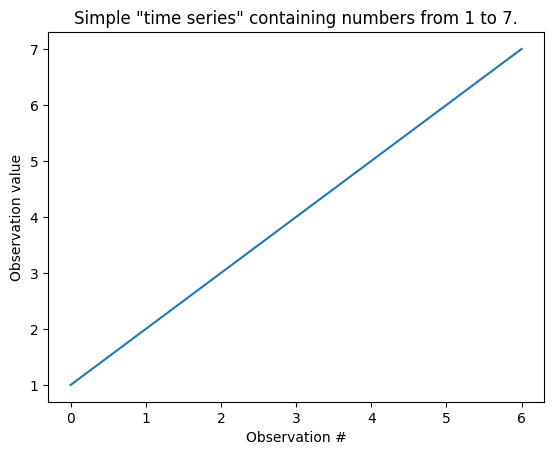

In [184]:
ts = [1, 2, 3, 4, 5, 6, 7]

pd.Series(ts).plot()
plt.title('Simple "time series" containing numbers from 1 to 7.')
plt.xlabel("Observation #")
plt.ylabel("Observation value")
plt.show()

The next number in this series would be 8. If we were to use naive forecasting, we would predict 7. How bad is this prediction?

The absolute error is 1 (of course). Is that good or bad? We don't know. Let's calculate the absolute percentage error.

In [185]:
# The predicted next value in the series is:
ts_next = ts[-1]

# The real next value in the series is:
real_ts_next = ts[-1] + 1

# The absolute percentage error for the predicted value is:
print(f"The absolute percentage error of our prediction is {abs((ts_next - real_ts_next) / real_ts_next) * 100 :.2f}%")



The absolute percentage error of our prediction is 12.50%


Not terrible.

## Demo 2: manual ARMA

Let's manually perform an ARMA prediction on the time series. We need  coefficients for this ($\beta_1, \beta_2, ..., \beta_k$). Finding out what these are is usually done by training. For this example let's simply give the last observation a weight of 1, the next to last one a weight of 0.1 and all the other observations a weight of 0.

In [186]:
weights = [0 for i in ts]
weights[-1] = 1
weights[-2] = 0.1
weights


[0, 0, 0, 0, 0, 0.1, 1]

Calculating the residuals is a bit tricky. Basically for every value except the first we need to calculate what the error would have been (the residual). The method below for doing this works, but is of course not elegant.

In [187]:
residuals  = [0] # The first residual is 0, because we cannot predict it
predicted = [1] # For demonstration purposes
for i in range(1, len(ts)):
    prev = ts[i - 1]
    prev_prev = ts[i - 2]
    predicted.append((prev * 1) + (prev_prev * 0.1))
    residuals.append(((prev * 1) + (prev_prev * 0.1)) - ts[i])

print(f'Real observations:\t{ts}')
print(f'Predicted observations:\t{predicted}')
print(f'Residuals:\t\t{residuals}')





Real observations:	[1, 2, 3, 4, 5, 6, 7]
Predicted observations:	[1, 1.7000000000000002, 2.1, 3.2, 4.3, 5.4, 6.5]
Residuals:		[0, -0.2999999999999998, -0.8999999999999999, -0.7999999999999998, -0.7000000000000002, -0.5999999999999996, -0.5]


Now let's combine the auto regression and the moving average (calculated by giving all but the last two values of the residuals a weight of 0) to predict the next value in the series

In [188]:
ma_weights = [0 for residual in residuals]
ma_weights[-1] = 1
ma_weights[-2] = 1
print(f'Weights for residuals:\t{ma_weights}')
arma = 0
for i in range(0, len(ts)):
    weight = weights[i]
    ma_weight = ma_weights[i]
    arma += ts[i] * weight
    arma += residuals[i] * ma_weight

print(f"Predicted value is {arma}. The absolute percentage error for this prediction is {abs((arma - ts[-1]) / ts[-1]) * 100 :.2f}%")


Weights for residuals:	[0, 0, 0, 0, 0, 1, 1]
Predicted value is 6.5. The absolute percentage error for this prediction is 7.14%


As you can see, even in this simple and highly artificial case ARMA performs better than naive forecasting.

NOTE: in "real" ARMA processing happens in reverse order (newest to oldest).

## Demo 3: manual ARMA, does not work

ARMA makes a few assumptions about the data. Here we see an example where ARME does not work.

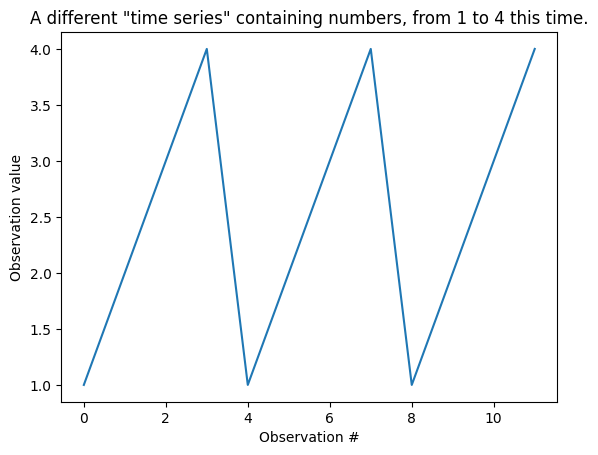

In [189]:
ts2 = [1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]

pd.Series(ts2).plot()
plt.title('A different "time series" containing numbers, from 1 to 4 this time.')
plt.xlabel("Observation #")
plt.ylabel("Observation value")
plt.show()

Once again, let's manually perform an ARMA prediction of the next value.

In [190]:
weights2 = [0 for i in ts2]
weights2[-1] = 1
weights2[-2] = 0.1
print(f'Weights:\t\t{weights2}')
residuals2  = [0] # The first residual is 0, because we cannot predict it
predicted2 = [1] # For demonstration purposes
for i in range(1, len(ts2)):
    prev = ts2[i - 1]
    prev_prev = ts2[i - 2]
    predicted2.append((prev * 1) + (prev_prev * 0.1))
    residuals2.append(((prev * 1) + (prev_prev * 0.1)) - ts2[i])

print(f'Real observations:\t{ts2}')
print(f'Predicted observations:\t{predicted2}')
print(f'Residuals:\t\t{residuals2}')

ma_weights2 = [0 for residual in residuals2]
ma_weights2[-1] = 1
ma_weights2[-2] = 1
print(f'Weights for residuals:\t{ma_weights2}')
arma2 = 0
for i in range(0, len(ts2)):
    weight = weights2[i]
    ma_weight = ma_weights2[i]
    arma2 += ts2[i] * weight
    arma2 += residuals2[i] * ma_weight

print(f"Predicted value is {arma2}. The absolute percentage error for this prediction is {abs((arma2 - ts2[-1]) / ts2[-1]) * 100 :.2f}%")




Weights:		[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 1]
Real observations:	[1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4]
Predicted observations:	[1, 1.4, 2.1, 3.2, 4.3, 1.4, 2.1, 3.2, 4.3, 1.4, 2.1, 3.2]
Residuals:		[0, -0.6000000000000001, -0.8999999999999999, -0.7999999999999998, 3.3, -0.6000000000000001, -0.8999999999999999, -0.7999999999999998, 3.3, -0.6000000000000001, -0.8999999999999999, -0.7999999999999998]
Weights for residuals:	[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
Predicted value is 2.6000000000000005. The absolute percentage error for this prediction is 35.00%


The reason the prediction is so far off is that ARMA assumes the time series is *stationary*, ie there is no so-called "seasonality" (recurring patterns) and overall trends in the data.

The second example time series clearly has a recurring pattern, which is why ARMA does not work.

## Demo 4: reducing seasonality using differencing

It is possible to remove overall trends and seasonality from a timeseries by using a technique called *differencing*. In this technique you calculate the difference (hence the name) between values in a time series and a shifted version of those values. This allows you to study the properties of the time series without the distraction of the seasonality.


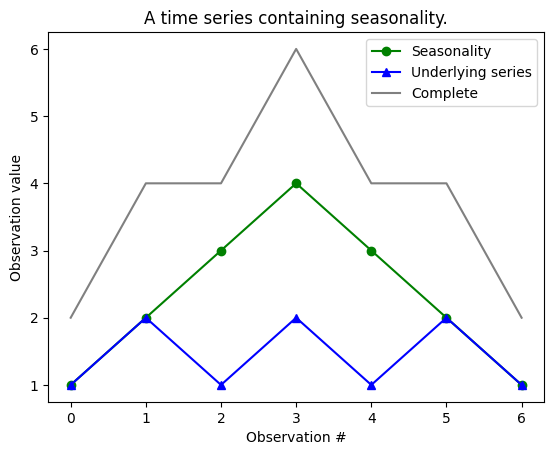

In [191]:
seasons = [1, 2, 3, 4, 3, 2, 1]
ts_noseasons = [1, 2, 1, 2, 1, 2, 1]
ts3 = list(map(lambda season, value: season + value, seasons, ts_noseasons))

pd.Series(seasons).plot(color='green', style='o-')
pd.Series(ts_noseasons).plot(color='blue', style='^-')
pd.Series(ts3).plot(color="gray")
plt.title('A time series containing seasonality.')
plt.xlabel("Observation #")
plt.ylabel("Observation value")
plt.legend(['Seasonality', 'Underlying series', 'Complete'])
plt.show()

Let's manually perform differencing. We create a new time series that contains the difference between each value and the previous value (this gives us - roughly - the *differential* of the time series at each point)

In [192]:
ts3_shifted = ts3[-1:]
ts3_shifted += ts3[:-1]
print(f'Original: \t{ts3}')
print(f'Shifted: \t{ts3_shifted}')
differenced = list(map(lambda orig, prev: orig - prev, ts3, ts3_shifted))
print(f'Difference: \t{differenced}')


Original: 	[2, 4, 4, 6, 4, 4, 2]
Shifted: 	[2, 2, 4, 4, 6, 4, 4]
Difference: 	[0, 2, 0, 2, -2, 0, -2]


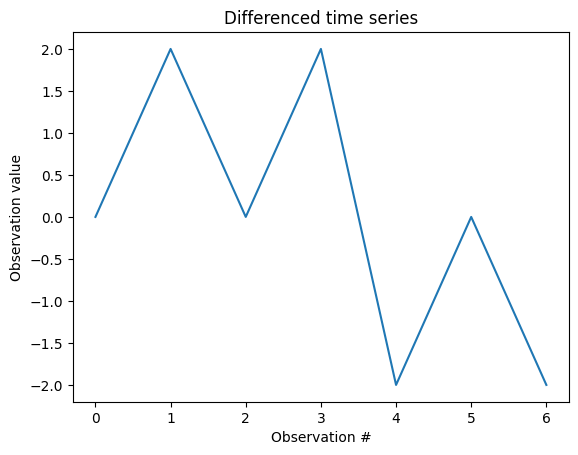

In [193]:
pd.Series(differenced).plot()
plt.title('Differenced time series')
plt.xlabel("Observation #")
plt.ylabel("Observation value")
plt.show()

This technique does not yield the underlying data without the seasonal trend (up and then down) as it was originally but it does give us a better view of it. You can clearly see the zig zag trend.

## Demo 5: using statsmodels.tsa to show trends and seasonality

In practice, we do not, of course, write our own buggy code to work with time series. Instead we use the Python statsmodels.tsa library.

(this example is copied from RaoulG's https://github.com/raoulg/MADS-DAV/blob/main/notebooks/03.2-statistics-of-time.ipynb)

For this example we will again use synthetic data. We will create:

- 3 years of data
- with 4 seasonal cycles per year
- we add a trend of +10 over the full period
- and we add some noise



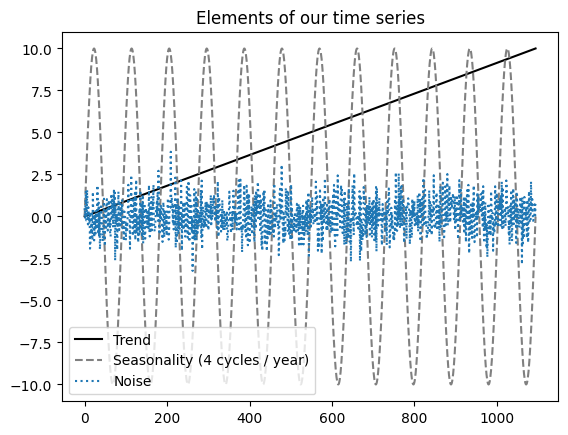

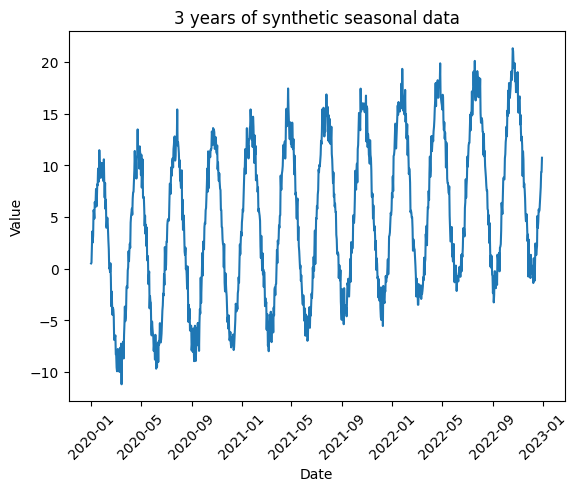

In [194]:
# Generate a date range
years = 3
dates = pd.date_range(start="2020-01-01", periods=365 * years, freq="D")

# Generate synthetic data with seasonality

# First create a linear trend
np.random.seed(42)
trend = np.linspace(0, 10, len(dates))


# Then add seasonality: for every year, create 4 cycles.
cycles = 4
seasonality = 10 * np.sin(
    np.linspace(0, cycles * years * 2 * np.pi, len(dates))
)  # Yearly seasonality



# Now create random noise. This is our time series *without* the seasonality and trend.
noise = np.random.normal(0, 1, len(dates))  # Random noise

pd.Series(trend).plot(color="black")
pd.Series(seasonality).plot(color="grey", linestyle="dashed")
pd.Series(noise).plot(linestyle="dotted")
plt.title('Elements of our time series')
plt.legend(['Trend', 'Seasonality (4 cycles / year)', 'Noise'])
plt.show()

# Finally, combine the trend, the seasonality and the noise.
synthetic_data = trend + seasonality + noise

# Create a DataFrame
df = pd.DataFrame({"Date": dates, "Value": synthetic_data})
plt.plot(df["Date"], df["Value"])
plt.xticks(rotation=45)
plt.title('3 years of synthetic seasonal data')
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

We can use the `statsmodels.graphics` library to uncover trends and seasonality in our data. The `plot_acf` (autocorrelation function plot) function shows you:
- 

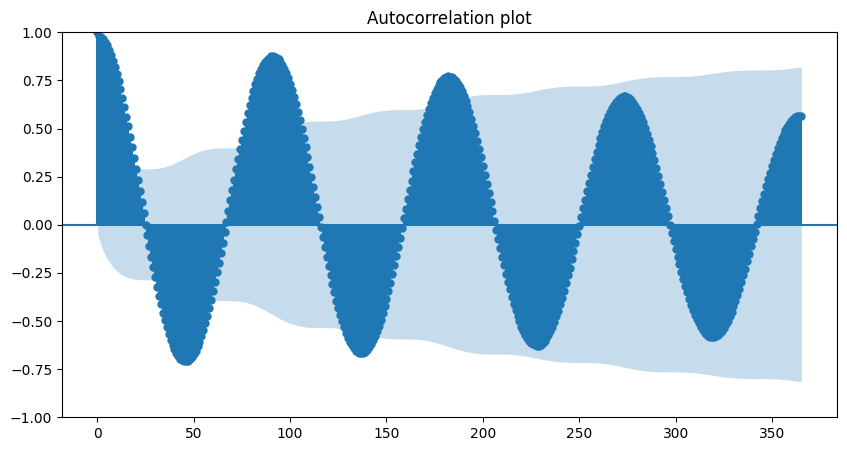

In [195]:
acf_plot = tsaplots.plot_acf(df["Value"], lags=365, title='Autocorrelation plot')

# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

# Show the plot
plt.show()

Values range from +1 to -1 and indicate how closely each value is correlated to past (lagged) values.
- +1 at the start makes sense (it's closely correlated to itself).
- After about 91.5 days the correlation is again strong, which makes sense because there are 4 cycles in one year.
- After 45.5 days the correlation is strong but negative, corresponding to the troughs in the seasonality (again, 4 per year).
- Correlations become weaker as the time difference becomes greater. This is due to the overall trend.


## Demo 6: Using statsmodels.tsa to decompose a time series

Statsmodels tsa can be used to decompose a time series into seasonal components. For synthetic data such as the one we used in demo 5, this works quite well.

We'll use the `statsmodels.tsa.seasonal` function.

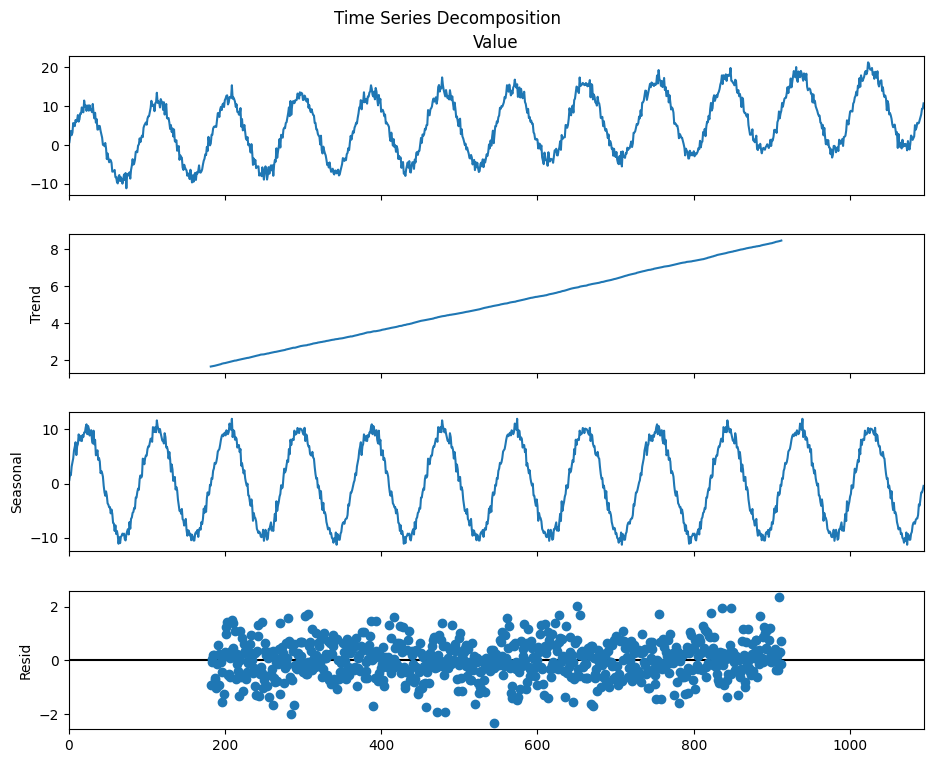

In [ ]:


# Decompose the time series
result = seasonal_decompose(df["Value"], model="additive", period=365)

# Plot the decomposed components
decomposed = result.plot()

decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Time Series Decomposition")

plt.show()

As you can see, `statsmodels.tsa.seasonal` has uncovered the trend we put in as well as our seasonal trend. The results aren't perfect (we *know* our seasonal effect graph should be smooth) but close enough.

## Demo 7: Using statsmodels.tsa to analyse and decompose sunspot data

Sunspots are famous for increasing and decreasing in intensity in 11 year cycles. You would therefore expect to be able to use autocorrelation function analysis to uncover underlying trends and patterns.
Let's see if this is in fact possible.

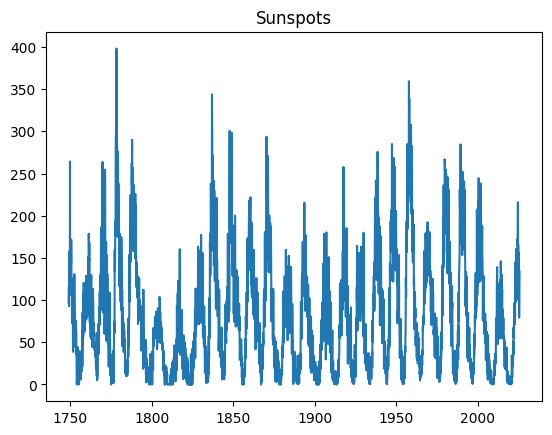

In [ ]:
# First load the data and show it.
df_sunspots = pd.read_csv('data/SN_m_tot_V2.0.txt',
    sep='\\s+',
    header=None,
    names=[
        "year",
        "month",
        "decimal_date",
        "sunspots",
        "std_dev",
        "observations",
        "definitive",
    ],
)

plt.plot(df_sunspots["decimal_date"], df_sunspots["sunspots"])
plt.title('Sunspots')
plt.show()

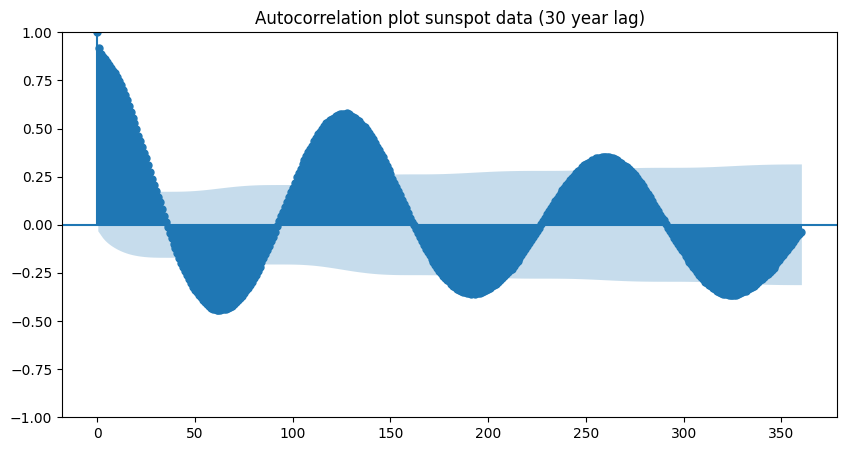

In [207]:
# Let's create an CSV plot.
acf_plot = tsaplots.plot_acf(
    df_sunspots["sunspots"], lags=30*12, title='Autocorrelation plot sunspot data (30 year lag)'
)  # lets go back 30 years (12 months each, each data point is one month)


# Adjust the plot size
acf_plot.set_figheight(5)
acf_plot.set_figwidth(10)

plt.show()

So far, so good. There seems to be a clear pattern in the data - as there should be: the cycle repeats every 11 years or 132 data points. The correlation is not strong, however - by the time the third cycle hits, it's less than 0.5.

Let's see what `seasonal_decompose` can tell us.

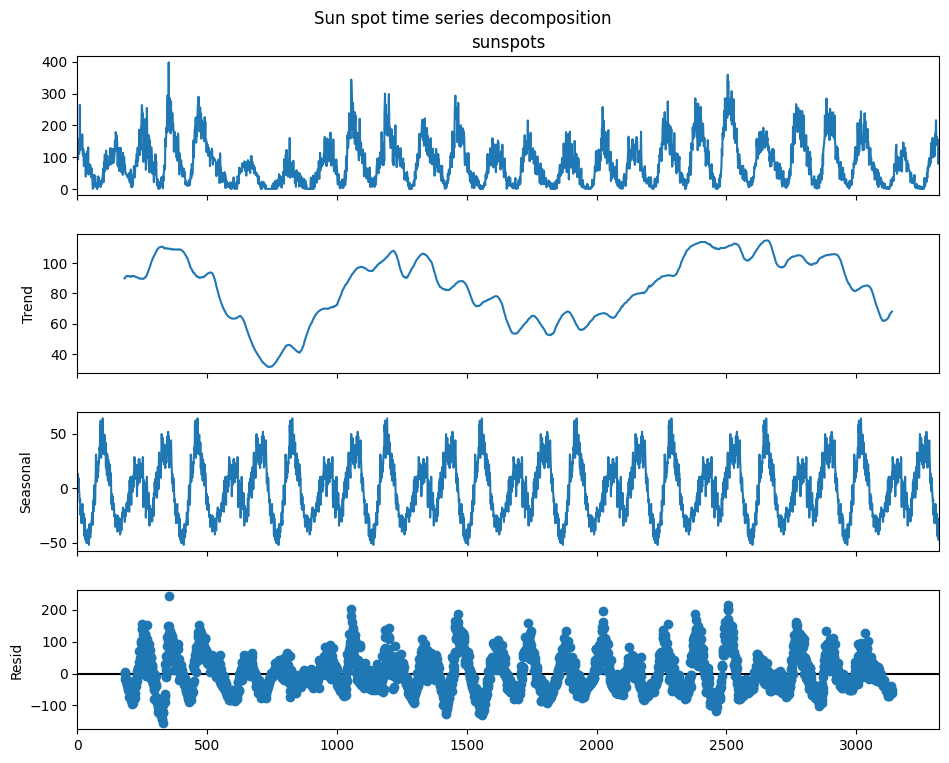

In [ ]:
# Perform a seasonal decompose of the sunspot data
result = seasonal_decompose(df_sunspots["sunspots"], model="additive", period=365)

decomposed = result.plot()
decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Sunspot time series decomposition")
plt.show()

Whoops - that's terrible. Both the trend (a roughly 100 year cycle) and the residuals seem to contain obvious additional sine wave type cycles (obvious, that is, to us, if we squint). Clearly the underlying pattern is too complex for the decomposition algorithm to pick up.

## Demo 8: smoothing data using filters

Often, small variations in data are not meaningful - they're "noise". This "noise" can, however, interfere with our analysis. Tools called "filters" can help "filter out" such "noise" so we can get a clearer picture of the data.

Let's create a synthetic time series with some noise and then filter it.

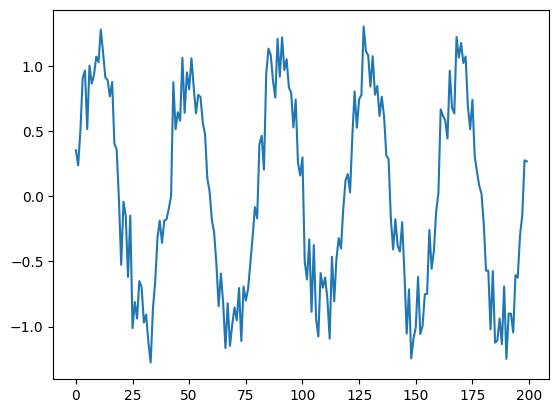

In [ ]:
# Generate a noisy sine wave for demonstration
np.random.seed(0)  # For reproducibility
time = np.linspace(0, 1, 200)  # 1 second, 200 samples
frequency = 5  # Frequency of the sine wave
amplitude = 1  # Amplitude of the sine wave
noise = np.random.normal(0, 0.2, time.shape)  # Gaussian noise
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)
noisy_signal = sine_wave + noise

pd.Series(noisy_signal).plot()
plt.title('A noisy sine wave signal')
plt.show()

The `scipy.signal` library contains some useful filters. Here we will apply two of them: Savitzky-Golay and the Butterworth low pass filter

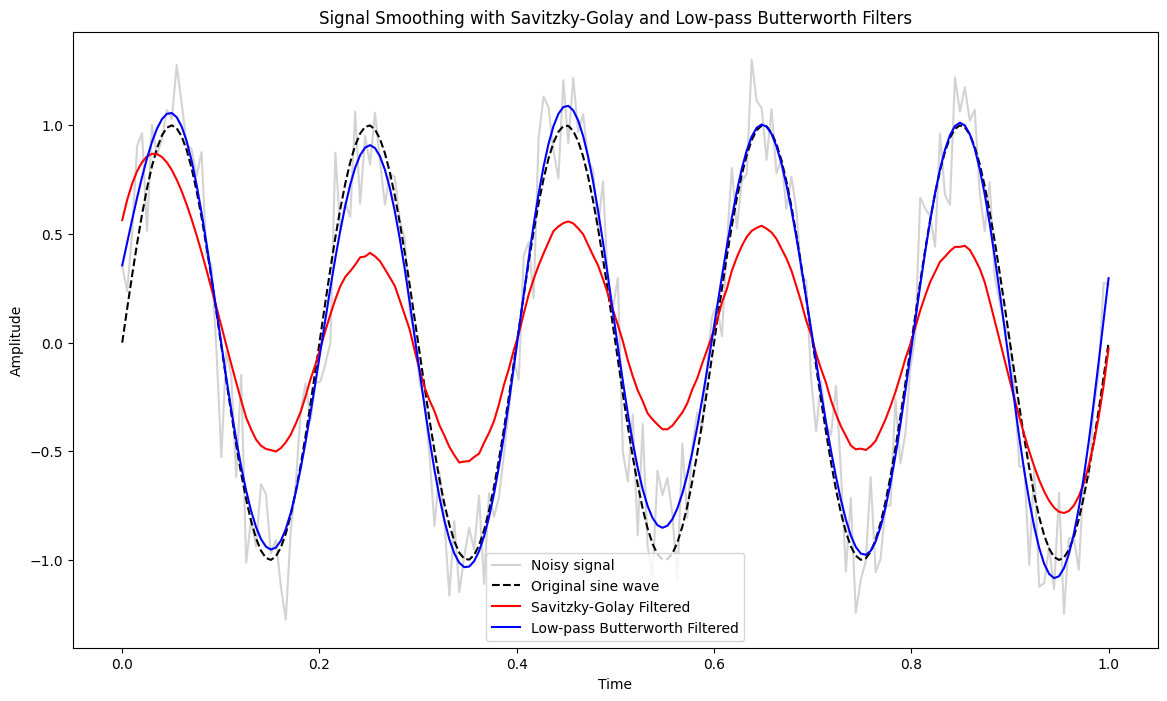

In [215]:
# Apply Savitzky-Golay filter
window_size = 51  # Window size should be odd
poly_order = 3  # Polynomial order
savitzky_golay_filtered = savgol_filter(noisy_signal, window_size, poly_order)

# Apply Low-pass Butterworth filter
cutoff_frequency = 0.1  # Cutoff frequency as a fraction of the sampling rate
filter_order = 3  # Filter order
b, a = butter(filter_order, cutoff_frequency, btype="low", analog=False)
butterworth_filtered = filtfilt(b, a, noisy_signal)

# Plot the original and filtered signals
plt.figure(figsize=(14, 8))
plt.plot(time, noisy_signal, label="Noisy signal", color="lightgray")
plt.plot(time, sine_wave, label="Original sine wave", linestyle="--", color="black")
plt.plot(time, savitzky_golay_filtered, label="Savitzky-Golay Filtered", color="red")
plt.plot(
    time, butterworth_filtered, label="Low-pass Butterworth Filtered", color="blue"
)
plt.legend()
plt.title("Signal Smoothing with Savitzky-Golay and Low-pass Butterworth Filters")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

Clearly, the Butterworth filter especially can remove noise so well that you almost get the original sine wave back.

## Demo 9: smoothing sunspot data using filters

Finally, let's see if smoothing the sunspot data using filters yields a better seasonality analysis.


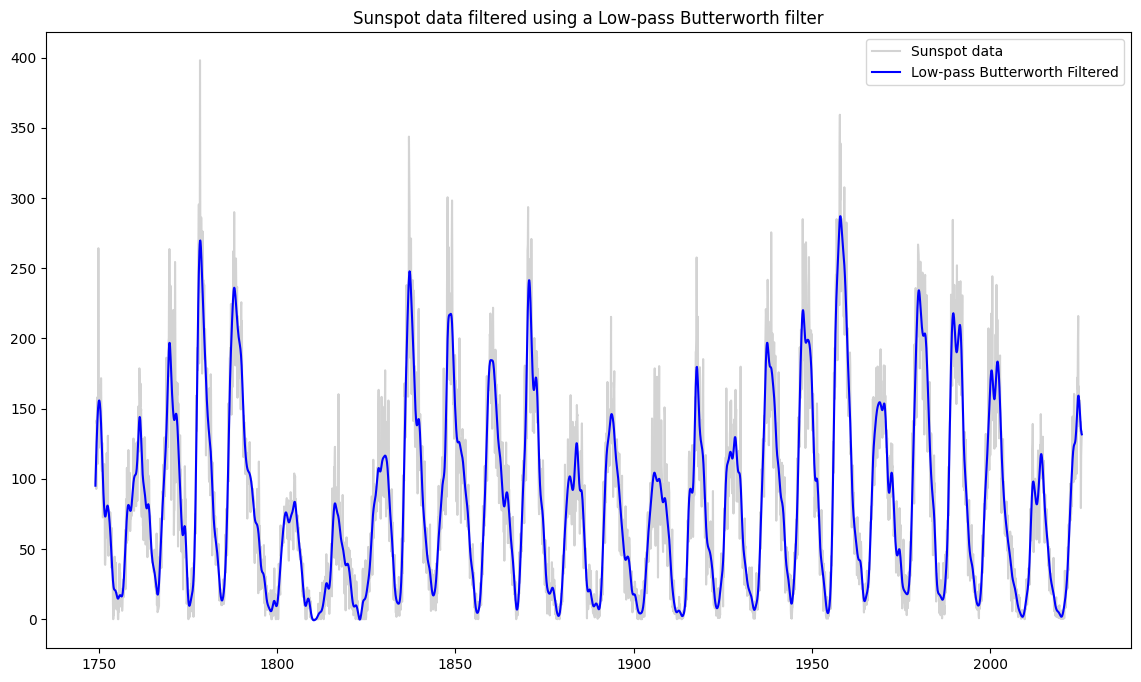

In [232]:
# Apply a Butterworth filter to the sunspot data (because Butterworth performed to well in the previous demo)

cutoff_frequency = 0.1  # Cutoff frequency as a fraction of the sampling rate
filter_order = 3  # Filter order
b, a = butter(filter_order, cutoff_frequency, btype="low", analog=False)
sunspots_filtered = filtfilt(b, a, df_sunspots["sunspots"] )

plt.figure(figsize=(14, 8))
plt.plot(df_sunspots["decimal_date"], df_sunspots["sunspots"], label="Sunspot data", color="lightgray")
plt.plot(
    df_sunspots["decimal_date"], sunspots_filtered, label="Low-pass Butterworth Filtered", color="blue"
)
plt.legend()
plt.title("Sunspot data filtered using a Low-pass Butterworth filter")
plt.show()


The graph certainly seems smoother. Let's see if the filtering we did has yielded data that is easier to decompose.

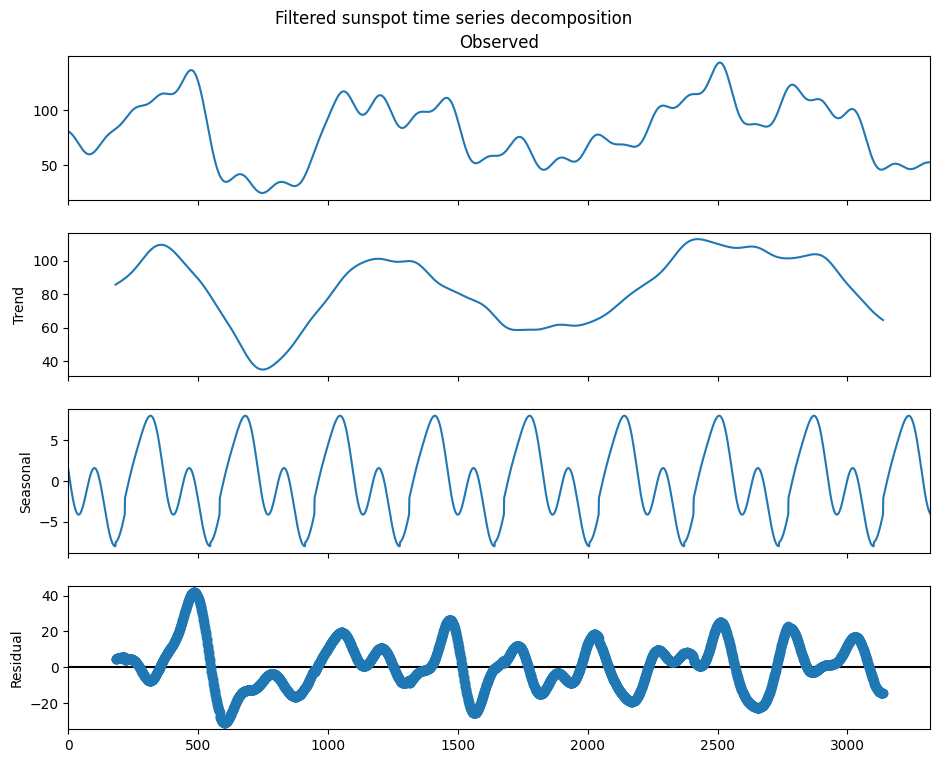

In [230]:
result = seasonal_decompose(sunspots_filtered, model="additive", period=365)

decomposed = result.plot()
decomposed.set_figheight(8)
decomposed.set_figwidth(10)
decomposed.suptitle("Filtered sunspot time series decomposition")
plt.show()

Well, no. The residuals certainly appear less noisy, but they still contain cyclical data the algorithm doesn't catch.
If you want, you can play around with the cutoff_frequency variable above to see if that changes things.
Ultimately, however, filtering will only get you so far. If the data is complex, no amount of filtering is going to change that fact.